In [178]:
# # QC tensorflow installation
# import tensorflow as tf
# import keras
# print(tf.__version__)
# print(keras.__version__)

# Command Space
# %

## Import Libraries

In [179]:
# Import required libraries
import numpy as np
import tensorflow as tf
# from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import os

## Load CIFAR-10 Dataset

We load the CIFAR-10 dataset, perform some preprocessing like normalization and one hot encoding of labels/targets.

In [180]:
import numpy as np
import os

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_cifar10_train_test(data_dir):
    """
    Function to load CIFAR-10 training and test data.

    Args:
    data_dir (str): Path to the directory containing CIFAR-10 data files.

    Returns:
    X_train (ndarray): Training data features
    Y_train (ndarray): Training data labels
    X_test (ndarray): Test data features
    Y_test (ndarray): Test data labels
    """
    X_train = []
    Y_train = []

    for i in range(1, 6):  # Load training data from 5 batches
        batch_file = os.path.join(data_dir, 'data_batch_' + str(i))
        batch_data = unpickle(batch_file)
        X_train.append(batch_data[b'data'])
        Y_train += batch_data[b'labels']

    X_train = np.concatenate(X_train, axis=0)
    Y_train = np.array(Y_train)

    # Load test data from the test batch
    test_batch_file = os.path.join(data_dir, 'test_batch')
    test_batch_data = unpickle(test_batch_file)

    X_test = test_batch_data[b'data']
    Y_test = np.array(test_batch_data[b'labels'])

    # Reshaping and re-arranging color channels to represent RGB image required as input to CNN
    # Reshape to (50000, 3, 32, 32) and move the color channel axis to the last dimension
    X_train = X_train.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    X_test = X_test.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

    return X_train, Y_train, X_test, Y_test


Create validation data from train set (20% split):

In [181]:
from sklearn.model_selection import train_test_split

# Directory containing CIFAR-10 data files
data_dir = 'dataset\cifar-10-python\cifar-10-batches-py'

# Load CIFAR-10 training and test data
X_train, Y_train, X_test, Y_test = load_cifar10_train_test(data_dir)

# Split the training data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

In [182]:
# Ensuring we parsed the data correctly:
print('Train Set:')
print('X_train shape: ', X_train.shape)
print('Y_train shape: ', Y_train.shape)
print('Validation Set:')
print('X_val shape: ', X_val.shape)
print('Y_val shape: ', Y_val.shape)
print('Test Set:')
print('X_test shape: ', X_test.shape)
print('Y_test shape: ', Y_test.shape)

Train Set:
X_train shape:  (40000, 32, 32, 3)
Y_train shape:  (40000,)
Validation Set:
X_val shape:  (10000, 32, 32, 3)
Y_val shape:  (10000,)
Test Set:
X_test shape:  (10000, 32, 32, 3)
Y_test shape:  (10000,)


### Setup ImageDataGenerator

In order to make the most of fewer training examples, we will "augment" them via a number of random transformations, so that our model would never see twice the exact same picture. This helps prevent overfitting and helps the model generalize better.

NOTE: ImageDataGenerator will NOT add new images to your data set in a sense that it will not make your epochs bigger. Instead, in each epoch it will provide slightly altered images (depending on your configuration). It will always generate new images, no matter how many epochs you have.

So in each epoch model will train on different images, but not too different. This should prevent overfitting and in some way simulates online learning.

In [183]:
from keras.preprocessing.image import ImageDataGenerator

# Construct the training image generator for data augmentation
# datagen = ImageDataGenerator(
#         rotation_range=10, # rotation
#         width_shift_range=0.2, # horizontal shift
#         height_shift_range=0.2, # vertical shift
#         zoom_range=0.2, # zoom
#         horizontal_flip=True, # horizontal flip
#         # brightness_range=[0.2,1.0] # brightness
# )

# For purposes of creating a baseline, construct empty ImageDataGenerator
datagen = ImageDataGenerator()

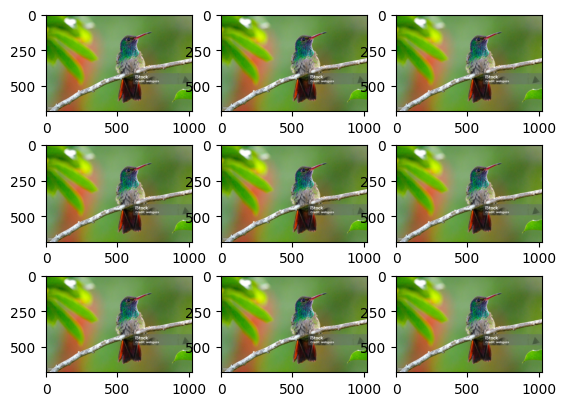

In [184]:
# Example of image augmentation on sample image:
from numpy import expand_dims
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from matplotlib import pyplot


img = load_img('bird.jpeg') # load image
data = img_to_array(img) # convert to numpy array
samples = expand_dims(data, 0) # expand dimension to one sample

# Prepare iterator
it = datagen.flow(samples, batch_size=1)

# Generate samples and plot
for i in range(9):
    pyplot.subplot(330 + 1 + i) # define subplot
    batch = it.next() # generate batch of images
    image = batch[0].astype('uint8') # convert to unsigned integers
    pyplot.imshow(image)

# show the figure
pyplot.show()
# Adapted code for displaying augmentation results: https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/

### Pre-processing dataset

In [185]:
# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0
X_val = X_val / 255.0

# One-hot encode the labels
Y_train = to_categorical(Y_train, 10)
Y_test = to_categorical(Y_test, 10)
Y_val = to_categorical(Y_val, 10)

## Build and Train Model

The following cell has the supporting utility functions to plot accuracy curves, loss curves from training process and final evaluation of the classification model. I have provided inline comments explaining purpose of each function and code used. 

In [186]:
# Import required libraries
import matplotlib.pyplot as plt

def plot_accuracy(history, title):
    """
    Function to plot accuracy curves for both training and validation sets.

    Args:
    history (History): Keras History object containing training history
    title (str): Title of the plot
    """
    new_title = title + " Accuracy"
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title(new_title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    save_plot(plt, new_title)
    plt.show()
    
def plot_multiple_accuracies(models, title):
    """
    Function to plot accuracy curves for both training and validation sets of multiple models at once.

    Args:
    models (Dictionary): Contains Keras History objects with training history assigned by keys that pertain to the hyperparameter value used
    title (str): Title of the plot
    """
    new_title = title + " Accuracy"
    for key in models.keys():
        history = models[key]
        plt.plot(history.history['accuracy'], label='train_accuracy' + "_" + key)
        plt.plot(history.history['val_accuracy'], label='val_accuracy' + "_" + key)
    plt.title(new_title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    save_plot(plt, new_title)
    plt.show()

def plot_loss(history, title):
    """
    Function to plot loss curves for both training and validation sets.

    Args:
    history (History): Keras History object containing training history
    title (str): Title of the plot
    """
    new_title = title + " Loss"
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(new_title = title + " Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    save_plot(plt, new_title = title + " Loss")
    plt.show()
    
def plot_multiple_losses(models, title):
    """
    Function to plot loss curves for both training and validation sets.

    Args:
    models (Dictionary): Contains Keras History objects with training history assigned by keys that pertain to the hyperparameter value used
    title (str): Title of the plot
    """
    new_title = title + " Loss"
    for key in models.keys():
        history = models[key]
        plt.plot(history.history['loss'], label='train_loss' + "_" + key)
        plt.plot(history.history['val_loss'], label='val_loss' + "_" + key)
    plt.title(new_title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    save_plot(plt, new_title)
    plt.show()

def evaluate_model(model, X_test, Y_test):
    """
    Function to evaluate the performance of a trained model on the test dataset.

    Args:
    model (Sequential): Trained Keras model
    X_test (ndarray): Test dataset features
    Y_test (ndarray): One-hot encoded labels for test dataset
    """
    _, accuracy = model.evaluate(X_test, Y_test, verbose=0)
    print("Test Accuracy: %.2f%%" % (accuracy * 100))
    return accuracy * 100
    
def save_plot(plt, name):
    """
    Function to save a plot. Call function before plt.show().

    Args:
    plt (matplotlib.pyplot object): Plot to save
    name (String): A String for the name of the output file. Cannot contain spaces
    """
    filepath = "Graphs/" + name
    # if os.path.isfile(filepath):
    #     filepath += "_second"
    #     print("Same filename. Please alter the params_string. You will not get another warning before losing figures!!")
    plt.savefig(filepath)


In [201]:
from tensorflow.keras.layers import Input, Add, Activation, AveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model

def resnet_block(inputs, filters, kernel_size, strides, skip_kernel_size=(1, 1), activation='relu', num_layers=2, dropout=0):
    """
    Function to create a single ResNet block.

    Args:
    inputs (tensor): Input tensor
    filters (int): Number of filters in the convolutional layers
    kernel_size (int or tuple): Size of the convolutional kernel
    strides (int or tuple): Strides of the convolutional kernel
    skip_kernel_size (int or tuple): Size of the skip connection kernel
    activation (str): Activation function to use
    num_layers (int): Number of convolutional layers per block

    Returns:
    tensor: Output tensor of the ResNet block
    """
    shortcut = inputs

    # Create initial convolutional layer and batch normalization without an activation layer afterwards
    x = Conv2D(filters, kernel_size, strides=strides, padding='same', kernel_initializer='he_normal')(inputs)
    x = Dropout(dropout)(x)
    x = BatchNormalization()(x)
    
    # Create (num_layers - 1) convolutional layers with activation layer beforehand
    # Final layer does not have an activation layer as desired
    if num_layers > 1:
        for i in range(num_layers - 1):
            x = Activation(activation)(x)
            x = Conv2D(filters, kernel_size, padding='same', kernel_initializer='he_normal')(x)
            x = Dropout(dropout)(x)
            x = BatchNormalization()(x)
    

    # Shortcut connection
    if strides != 1 or inputs.shape[-1] != filters:
        # change (1,1) to variable (the kernel size in the ith skip connection)
        shortcut = Conv2D(filters, skip_kernel_size, strides=strides, padding='same', kernel_initializer='he_normal')(inputs)
        shortcut = Dropout(dropout)(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation(activation)(x)
    return x

def build_resnet(init_filters=64, res_layers=[2, 2], conv_kernel_size=(3,3), skip_kernel_size=(1, 1), conv_per_layer=2, pool_size=(8, 8), optimizer='adam', dropout=0):
    """
    Function to build a ResNet model using multiple Resnet style blocks.
    
    Args:
    init_filters (int): Number of filters in the first layer
    res_layers (list of ints): Network architecture as a list where the length of the list is the number of Residual Layers and the value of each element is the number of blocks in that layer
    conv_kernel_size (int or tuple): Size of the convolutional kernel
    skip_kernel_size (int or tuple): Size of the skip connection kernel
    conv_per_layer (int): Number of convolutional layers per residual block
    pool_size (int or tuple): Size of the pooling layer
    optimizer (String): Acceptable keras optimizers such as SGD or adam

    Returns:
    model (Model): Compiled ResNet model
    """
    inputs = Input(shape=(32, 32, 3))
    num_filters = init_filters
    num_blocks_list = res_layers  # ResNet Style architecture for CIFAR-10

    x = Conv2D(num_filters, conv_kernel_size, padding='same', kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Add ResNet blocks
    for i, num_blocks in enumerate(num_blocks_list):
        for j in range(num_blocks):
            strides = 1
            if i > 0 and j == 0:  # Downsample at the beginning of each stage
                strides = 2
            x = resnet_block(x, num_filters, conv_kernel_size, strides, skip_kernel_size=skip_kernel_size, num_layers=conv_per_layer, dropout=dropout)

        num_filters *= 2  # Double the number of filters after each stage

    x = AveragePooling2D(pool_size=pool_size)(x) # pool size could be hyperparameter
    x = Flatten()(x)
    outputs = Dense(10, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    # optimizer can be a parameter: vanilla sgd, sgd with fixed learning rate, or adam 
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [202]:
# Build ResNet Model 1
resnet_model_1 = build_resnet(init_filters=64, res_layers=[2, 2], conv_kernel_size=(3,3), skip_kernel_size=(1, 1), conv_per_layer=2, pool_size=(2, 2), optimizer='SGD', dropout=0)
resnet_model_1.summary()

Model: "model_41"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_42 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_452 (Conv2D)            (None, 32, 32, 64)   1792        ['input_42[0][0]']               
                                                                                                  
 batch_normalization_452 (Batch  (None, 32, 32, 64)  256         ['conv2d_452[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_409 (Activation)    (None, 32, 32, 64)   0           ['batch_normalization_452[

In [203]:
# Build ResNet Model 2
resnet_model_2 = build_resnet(init_filters=64, res_layers=[2, 2], conv_kernel_size=(3,3), skip_kernel_size=(1, 1), conv_per_layer=2, pool_size=(2, 2), optimizer='SGD', dropout=0.1)
resnet_model_2.summary()

Model: "model_42"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_43 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_462 (Conv2D)            (None, 32, 32, 64)   1792        ['input_43[0][0]']               
                                                                                                  
 batch_normalization_462 (Batch  (None, 32, 32, 64)  256         ['conv2d_462[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_418 (Activation)    (None, 32, 32, 64)   0           ['batch_normalization_462[

In [204]:
# Build ResNet Model 3
resnet_model_3 = build_resnet(init_filters=64, res_layers=[2, 2], conv_kernel_size=(3,3), skip_kernel_size=(1, 1), conv_per_layer=2, pool_size=(2, 2), optimizer='SGD', dropout=0.25)
resnet_model_3.summary()

Model: "model_43"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_44 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_472 (Conv2D)            (None, 32, 32, 64)   1792        ['input_44[0][0]']               
                                                                                                  
 batch_normalization_472 (Batch  (None, 32, 32, 64)  256         ['conv2d_472[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_427 (Activation)    (None, 32, 32, 64)   0           ['batch_normalization_472[

In [206]:
# Build ResNet Model 4
resnet_model_4 = build_resnet(init_filters=64, res_layers=[2, 2], conv_kernel_size=(3,3), skip_kernel_size=(1, 1), conv_per_layer=2, pool_size=(2, 2), optimizer='SGD', dropout=0.3)
resnet_model_4.summary()

Model: "model_45"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_46 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_500 (Conv2D)            (None, 32, 32, 64)   1792        ['input_46[0][0]']               
                                                                                                  
 batch_normalization_500 (Batch  (None, 32, 32, 64)  256         ['conv2d_500[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_453 (Activation)    (None, 32, 32, 64)   0           ['batch_normalization_500[

TO DO:
1. keras callbacks: save checkpoint with best performance on validation data (rishie)
2. Add hyperparameter tuning as arguments (gio)
3. Save graphs under different names (gio)
4. ImageDataGenerator - read about this to add augmentation (rishie)
5. Regularization - Dropouts in random/hyperparameter
6. Loading custom data (rishie)

### Enabling Keras Callbacks

Callback to save the Keras model weights after every epoch that obtains the best validation accuracy thus far.

In [192]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Title of the Hypothesis Tested
title = "Varying Dropout Layer Percentage"

# These are used to distinguish the models from each other
param_1 = "2x2 Avg Pool"
param_2 = "4x4 Avg Pool"
param_3 = "8x8 Avg Pool"
param_4 = "Four Blocks Per Layer"

checkpoint_filepath_1 = 'ckpt/' + title + '/' + param_1
checkpoint_filepath_2 = 'ckpt/' + title + '/' + param_2 
checkpoint_filepath_3 = 'ckpt/' + title + '/' + param_3
checkpoint_filepath_4 = 'ckpt/' + title + '/' + param_4

# Defining callback
model_checkpoint_callback_1 = ModelCheckpoint(
    filepath=checkpoint_filepath_1,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

model_checkpoint_callback_2 = ModelCheckpoint(
    filepath=checkpoint_filepath_2,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

model_checkpoint_callback_3 = ModelCheckpoint(
    filepath=checkpoint_filepath_3,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

model_checkpoint_callback_4 = ModelCheckpoint(
    filepath=checkpoint_filepath_4,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [193]:
# Augmenting on the fly with datagen.flow()
batch_size=64
epochs=30

# For running multiple networks at the same time, create dictionary to store history values and lists to store all other info
histories = {}
keys = [param_1, param_2, param_3] #, param_4
models = [resnet_model_1, resnet_model_2, resnet_model_3] #, resnet_model_4
checkpoints = [model_checkpoint_callback_1, model_checkpoint_callback_2, model_checkpoint_callback_3] #, model_checkpoint_callback_4
# Explain whats happening here!!!
for i in range(len(models)):
# Directly use .flow() to load our dataset in batches for training
    histories[keys[i]] = models[i].fit(datagen.flow(X_train, Y_train, batch_size=batch_size), 
                                    epochs = epochs, # set number of epochs
                                    steps_per_epoch = X_train.shape[0]//batch_size, # number of images composing one epoch
                                    validation_data = (X_val, Y_val), # data for validation
                                    callbacks=[checkpoints[i]], # model checkpoint
                                    verbose=1)

Epoch 1/30
623/625 [============================>.] - ETA: 0s - loss: 2.1121 - accuracy: 0.4149

INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\2x2 Avg Pool\assets


INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\2x2 Avg Pool\assets


625/625 [==============================] - 13s 19ms/step - loss: 2.1099 - accuracy: 0.4153 - val_loss: 1.3494 - val_accuracy: 0.5352
Epoch 2/30
621/625 [============================>.] - ETA: 0s - loss: 1.2545 - accuracy: 0.5552

INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\2x2 Avg Pool\assets


INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\2x2 Avg Pool\assets


625/625 [==============================] - 12s 18ms/step - loss: 1.2546 - accuracy: 0.5549 - val_loss: 1.1104 - val_accuracy: 0.6095
Epoch 3/30
625/625 [==============================] - ETA: 0s - loss: 1.0441 - accuracy: 0.6337

INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\2x2 Avg Pool\assets


INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\2x2 Avg Pool\assets


625/625 [==============================] - 11s 18ms/step - loss: 1.0441 - accuracy: 0.6337 - val_loss: 1.1198 - val_accuracy: 0.6108
Epoch 4/30
621/625 [============================>.] - ETA: 0s - loss: 0.9160 - accuracy: 0.6767

INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\2x2 Avg Pool\assets


INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\2x2 Avg Pool\assets


625/625 [==============================] - 11s 18ms/step - loss: 0.9159 - accuracy: 0.6769 - val_loss: 1.0044 - val_accuracy: 0.6519
Epoch 5/30
625/625 [==============================] - 9s 14ms/step - loss: 0.8133 - accuracy: 0.7136 - val_loss: 1.0286 - val_accuracy: 0.6462
Epoch 6/30
625/625 [==============================] - 9s 14ms/step - loss: 0.7263 - accuracy: 0.7434 - val_loss: 1.0882 - val_accuracy: 0.6318
Epoch 7/30
623/625 [============================>.] - ETA: 0s - loss: 0.6485 - accuracy: 0.7736

INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\2x2 Avg Pool\assets


INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\2x2 Avg Pool\assets


625/625 [==============================] - 11s 17ms/step - loss: 0.6480 - accuracy: 0.7739 - val_loss: 0.8686 - val_accuracy: 0.6998
Epoch 8/30
625/625 [==============================] - 9s 14ms/step - loss: 0.5882 - accuracy: 0.7944 - val_loss: 1.0287 - val_accuracy: 0.6616
Epoch 9/30
625/625 [==============================] - 9s 15ms/step - loss: 0.5238 - accuracy: 0.8195 - val_loss: 0.9617 - val_accuracy: 0.6914
Epoch 10/30
625/625 [==============================] - 9s 15ms/step - loss: 0.4579 - accuracy: 0.8427 - val_loss: 1.0034 - val_accuracy: 0.6776
Epoch 11/30
622/625 [============================>.] - ETA: 0s - loss: 0.4007 - accuracy: 0.8641

INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\2x2 Avg Pool\assets


INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\2x2 Avg Pool\assets


625/625 [==============================] - 12s 19ms/step - loss: 0.4006 - accuracy: 0.8642 - val_loss: 0.8700 - val_accuracy: 0.7121
Epoch 12/30
625/625 [==============================] - 9s 15ms/step - loss: 0.3510 - accuracy: 0.8831 - val_loss: 0.9810 - val_accuracy: 0.6906
Epoch 13/30
625/625 [==============================] - 9s 15ms/step - loss: 0.3036 - accuracy: 0.9020 - val_loss: 0.9525 - val_accuracy: 0.7066
Epoch 14/30
622/625 [============================>.] - ETA: 0s - loss: 0.2548 - accuracy: 0.9203

INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\2x2 Avg Pool\assets


INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\2x2 Avg Pool\assets


625/625 [==============================] - 12s 19ms/step - loss: 0.2548 - accuracy: 0.9203 - val_loss: 0.9060 - val_accuracy: 0.7203
Epoch 15/30
624/625 [============================>.] - ETA: 0s - loss: 0.2168 - accuracy: 0.9367

INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\2x2 Avg Pool\assets


INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\2x2 Avg Pool\assets


625/625 [==============================] - 12s 19ms/step - loss: 0.2167 - accuracy: 0.9368 - val_loss: 0.8943 - val_accuracy: 0.7225
Epoch 16/30
625/625 [==============================] - ETA: 0s - loss: 0.1772 - accuracy: 0.9531

INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\2x2 Avg Pool\assets


INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\2x2 Avg Pool\assets


625/625 [==============================] - 12s 20ms/step - loss: 0.1772 - accuracy: 0.9531 - val_loss: 0.8965 - val_accuracy: 0.7304
Epoch 17/30
625/625 [==============================] - 10s 15ms/step - loss: 0.1506 - accuracy: 0.9635 - val_loss: 0.9618 - val_accuracy: 0.7231
Epoch 18/30
625/625 [==============================] - 9s 15ms/step - loss: 0.1214 - accuracy: 0.9752 - val_loss: 1.0114 - val_accuracy: 0.7104
Epoch 19/30
624/625 [============================>.] - ETA: 0s - loss: 0.0993 - accuracy: 0.9824

INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\2x2 Avg Pool\assets


INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\2x2 Avg Pool\assets


625/625 [==============================] - 12s 19ms/step - loss: 0.0993 - accuracy: 0.9825 - val_loss: 0.9038 - val_accuracy: 0.7391
Epoch 20/30
625/625 [==============================] - 10s 15ms/step - loss: 0.0822 - accuracy: 0.9881 - val_loss: 0.9099 - val_accuracy: 0.7365
Epoch 21/30
622/625 [============================>.] - ETA: 0s - loss: 0.0675 - accuracy: 0.9926

INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\2x2 Avg Pool\assets


INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\2x2 Avg Pool\assets


625/625 [==============================] - 12s 19ms/step - loss: 0.0676 - accuracy: 0.9926 - val_loss: 0.9338 - val_accuracy: 0.7407
Epoch 22/30
625/625 [==============================] - 10s 15ms/step - loss: 0.0572 - accuracy: 0.9949 - val_loss: 0.9947 - val_accuracy: 0.7292
Epoch 23/30
625/625 [==============================] - 9s 15ms/step - loss: 0.0469 - accuracy: 0.9969 - val_loss: 0.9751 - val_accuracy: 0.7354
Epoch 24/30
623/625 [============================>.] - ETA: 0s - loss: 0.0395 - accuracy: 0.9981

INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\2x2 Avg Pool\assets


INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\2x2 Avg Pool\assets


625/625 [==============================] - 12s 19ms/step - loss: 0.0395 - accuracy: 0.9981 - val_loss: 0.9257 - val_accuracy: 0.7474
Epoch 25/30
625/625 [==============================] - 10s 15ms/step - loss: 0.0344 - accuracy: 0.9987 - val_loss: 0.9353 - val_accuracy: 0.7463
Epoch 26/30
625/625 [==============================] - 9s 15ms/step - loss: 0.0309 - accuracy: 0.9985 - val_loss: 0.9965 - val_accuracy: 0.7380
Epoch 27/30
625/625 [==============================] - 9s 15ms/step - loss: 0.0273 - accuracy: 0.9992 - val_loss: 0.9702 - val_accuracy: 0.7467
Epoch 28/30
624/625 [============================>.] - ETA: 0s - loss: 0.0245 - accuracy: 0.9993

INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\2x2 Avg Pool\assets


INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\2x2 Avg Pool\assets


625/625 [==============================] - 12s 20ms/step - loss: 0.0245 - accuracy: 0.9993 - val_loss: 0.9498 - val_accuracy: 0.7503
Epoch 29/30
625/625 [==============================] - 9s 15ms/step - loss: 0.0224 - accuracy: 0.9995 - val_loss: 0.9857 - val_accuracy: 0.7480
Epoch 30/30
622/625 [============================>.] - ETA: 0s - loss: 0.0192 - accuracy: 0.9997

INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\2x2 Avg Pool\assets


INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\2x2 Avg Pool\assets


625/625 [==============================] - 12s 18ms/step - loss: 0.0192 - accuracy: 0.9997 - val_loss: 0.9650 - val_accuracy: 0.7528
Epoch 1/30
623/625 [============================>.] - ETA: 0s - loss: 1.5520 - accuracy: 0.4440

INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\4x4 Avg Pool\assets


INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\4x4 Avg Pool\assets


625/625 [==============================] - 13s 19ms/step - loss: 1.5510 - accuracy: 0.4443 - val_loss: 1.3172 - val_accuracy: 0.5379
Epoch 2/30
625/625 [==============================] - ETA: 0s - loss: 1.1827 - accuracy: 0.5788

INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\4x4 Avg Pool\assets


INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\4x4 Avg Pool\assets


625/625 [==============================] - 12s 20ms/step - loss: 1.1827 - accuracy: 0.5788 - val_loss: 1.1037 - val_accuracy: 0.6096
Epoch 3/30
624/625 [============================>.] - ETA: 0s - loss: 1.0224 - accuracy: 0.6393

INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\4x4 Avg Pool\assets


INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\4x4 Avg Pool\assets


625/625 [==============================] - 12s 19ms/step - loss: 1.0226 - accuracy: 0.6393 - val_loss: 1.0742 - val_accuracy: 0.6158
Epoch 4/30
625/625 [==============================] - 10s 15ms/step - loss: 0.9163 - accuracy: 0.6792 - val_loss: 1.1635 - val_accuracy: 0.5883
Epoch 5/30
625/625 [==============================] - ETA: 0s - loss: 0.8290 - accuracy: 0.7106

INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\4x4 Avg Pool\assets


INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\4x4 Avg Pool\assets


625/625 [==============================] - 12s 19ms/step - loss: 0.8290 - accuracy: 0.7106 - val_loss: 1.0455 - val_accuracy: 0.6402
Epoch 6/30
623/625 [============================>.] - ETA: 0s - loss: 0.7611 - accuracy: 0.7364

INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\4x4 Avg Pool\assets


INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\4x4 Avg Pool\assets


625/625 [==============================] - 12s 19ms/step - loss: 0.7613 - accuracy: 0.7364 - val_loss: 0.8525 - val_accuracy: 0.7065
Epoch 7/30
625/625 [==============================] - 10s 15ms/step - loss: 0.7041 - accuracy: 0.7581 - val_loss: 0.8991 - val_accuracy: 0.6867
Epoch 8/30
624/625 [============================>.] - ETA: 0s - loss: 0.6531 - accuracy: 0.7732

INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\4x4 Avg Pool\assets


INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\4x4 Avg Pool\assets


625/625 [==============================] - 12s 20ms/step - loss: 0.6534 - accuracy: 0.7732 - val_loss: 0.8590 - val_accuracy: 0.7090
Epoch 9/30
623/625 [============================>.] - ETA: 0s - loss: 0.6057 - accuracy: 0.7921

INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\4x4 Avg Pool\assets


INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\4x4 Avg Pool\assets


625/625 [==============================] - 12s 19ms/step - loss: 0.6057 - accuracy: 0.7921 - val_loss: 0.8252 - val_accuracy: 0.7184
Epoch 10/30
624/625 [============================>.] - ETA: 0s - loss: 0.5676 - accuracy: 0.8049

INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\4x4 Avg Pool\assets


INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\4x4 Avg Pool\assets


625/625 [==============================] - 12s 20ms/step - loss: 0.5678 - accuracy: 0.8048 - val_loss: 0.7909 - val_accuracy: 0.7326
Epoch 11/30
625/625 [==============================] - ETA: 0s - loss: 0.5253 - accuracy: 0.8209

INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\4x4 Avg Pool\assets


INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\4x4 Avg Pool\assets


625/625 [==============================] - 12s 19ms/step - loss: 0.5253 - accuracy: 0.8209 - val_loss: 0.7753 - val_accuracy: 0.7382
Epoch 12/30
623/625 [============================>.] - ETA: 0s - loss: 0.4942 - accuracy: 0.8308

INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\4x4 Avg Pool\assets


INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\4x4 Avg Pool\assets


625/625 [==============================] - 12s 19ms/step - loss: 0.4947 - accuracy: 0.8305 - val_loss: 0.7817 - val_accuracy: 0.7385
Epoch 13/30
625/625 [==============================] - 10s 15ms/step - loss: 0.4562 - accuracy: 0.8468 - val_loss: 0.8154 - val_accuracy: 0.7354
Epoch 14/30
622/625 [============================>.] - ETA: 0s - loss: 0.4225 - accuracy: 0.8589

INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\4x4 Avg Pool\assets


INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\4x4 Avg Pool\assets


625/625 [==============================] - 12s 19ms/step - loss: 0.4228 - accuracy: 0.8587 - val_loss: 0.7697 - val_accuracy: 0.7417
Epoch 15/30
625/625 [==============================] - 10s 15ms/step - loss: 0.3923 - accuracy: 0.8681 - val_loss: 0.9243 - val_accuracy: 0.7085
Epoch 16/30
625/625 [==============================] - 9s 15ms/step - loss: 0.3627 - accuracy: 0.8813 - val_loss: 0.8079 - val_accuracy: 0.7394
Epoch 17/30
625/625 [==============================] - 9s 15ms/step - loss: 0.3350 - accuracy: 0.8916 - val_loss: 0.8670 - val_accuracy: 0.7264
Epoch 18/30
622/625 [============================>.] - ETA: 0s - loss: 0.3040 - accuracy: 0.9030

INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\4x4 Avg Pool\assets


INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\4x4 Avg Pool\assets


625/625 [==============================] - 12s 19ms/step - loss: 0.3040 - accuracy: 0.9029 - val_loss: 0.8132 - val_accuracy: 0.7418
Epoch 19/30
625/625 [==============================] - 10s 15ms/step - loss: 0.2803 - accuracy: 0.9122 - val_loss: 0.9425 - val_accuracy: 0.7137
Epoch 20/30
625/625 [==============================] - 9s 15ms/step - loss: 0.2519 - accuracy: 0.9247 - val_loss: 0.8881 - val_accuracy: 0.7267
Epoch 21/30
624/625 [============================>.] - ETA: 0s - loss: 0.2298 - accuracy: 0.9320

INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\4x4 Avg Pool\assets


INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\4x4 Avg Pool\assets


625/625 [==============================] - 12s 19ms/step - loss: 0.2297 - accuracy: 0.9321 - val_loss: 0.7998 - val_accuracy: 0.7510
Epoch 22/30
625/625 [==============================] - 10s 15ms/step - loss: 0.2059 - accuracy: 0.9406 - val_loss: 0.8733 - val_accuracy: 0.7336
Epoch 23/30
625/625 [==============================] - 9s 15ms/step - loss: 0.1836 - accuracy: 0.9505 - val_loss: 0.8057 - val_accuracy: 0.7487
Epoch 24/30
625/625 [==============================] - 9s 15ms/step - loss: 0.1673 - accuracy: 0.9560 - val_loss: 0.9819 - val_accuracy: 0.7154
Epoch 25/30
623/625 [============================>.] - ETA: 0s - loss: 0.1464 - accuracy: 0.9639

INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\4x4 Avg Pool\assets


INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\4x4 Avg Pool\assets


625/625 [==============================] - 12s 19ms/step - loss: 0.1463 - accuracy: 0.9639 - val_loss: 0.8301 - val_accuracy: 0.7526
Epoch 26/30
622/625 [============================>.] - ETA: 0s - loss: 0.1298 - accuracy: 0.9699

INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\4x4 Avg Pool\assets


INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\4x4 Avg Pool\assets


625/625 [==============================] - 12s 20ms/step - loss: 0.1297 - accuracy: 0.9699 - val_loss: 0.8369 - val_accuracy: 0.7558
Epoch 27/30
622/625 [============================>.] - ETA: 0s - loss: 0.1123 - accuracy: 0.9757

INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\4x4 Avg Pool\assets


INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\4x4 Avg Pool\assets


625/625 [==============================] - 12s 19ms/step - loss: 0.1124 - accuracy: 0.9755 - val_loss: 0.7868 - val_accuracy: 0.7640
Epoch 28/30
622/625 [============================>.] - ETA: 0s - loss: 0.0988 - accuracy: 0.9813

INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\4x4 Avg Pool\assets


INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\4x4 Avg Pool\assets


625/625 [==============================] - 12s 20ms/step - loss: 0.0988 - accuracy: 0.9814 - val_loss: 0.7578 - val_accuracy: 0.7697
Epoch 29/30
625/625 [==============================] - 10s 15ms/step - loss: 0.0856 - accuracy: 0.9860 - val_loss: 0.8241 - val_accuracy: 0.7644
Epoch 30/30
623/625 [============================>.] - ETA: 0s - loss: 0.0747 - accuracy: 0.9889

INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\4x4 Avg Pool\assets


INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\4x4 Avg Pool\assets


625/625 [==============================] - 12s 19ms/step - loss: 0.0747 - accuracy: 0.9889 - val_loss: 0.7646 - val_accuracy: 0.7758
Epoch 1/30
625/625 [==============================] - ETA: 0s - loss: 1.6104 - accuracy: 0.4176

INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\8x8 Avg Pool\assets


INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\8x8 Avg Pool\assets


625/625 [==============================] - 13s 19ms/step - loss: 1.6104 - accuracy: 0.4176 - val_loss: 1.4208 - val_accuracy: 0.4849
Epoch 2/30
623/625 [============================>.] - ETA: 0s - loss: 1.2959 - accuracy: 0.5339

INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\8x8 Avg Pool\assets


INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\8x8 Avg Pool\assets


625/625 [==============================] - 12s 20ms/step - loss: 1.2958 - accuracy: 0.5340 - val_loss: 1.2738 - val_accuracy: 0.5368
Epoch 3/30
625/625 [==============================] - ETA: 0s - loss: 1.1472 - accuracy: 0.5917

INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\8x8 Avg Pool\assets


INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\8x8 Avg Pool\assets


625/625 [==============================] - 12s 19ms/step - loss: 1.1472 - accuracy: 0.5917 - val_loss: 1.1523 - val_accuracy: 0.5883
Epoch 4/30
625/625 [==============================] - 9s 15ms/step - loss: 1.0418 - accuracy: 0.6321 - val_loss: 1.2203 - val_accuracy: 0.5601
Epoch 5/30
622/625 [============================>.] - ETA: 0s - loss: 0.9575 - accuracy: 0.6648

INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\8x8 Avg Pool\assets


INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\8x8 Avg Pool\assets


625/625 [==============================] - 12s 20ms/step - loss: 0.9579 - accuracy: 0.6645 - val_loss: 1.0573 - val_accuracy: 0.6292
Epoch 6/30
623/625 [============================>.] - ETA: 0s - loss: 0.8872 - accuracy: 0.6886

INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\8x8 Avg Pool\assets


INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\8x8 Avg Pool\assets


625/625 [==============================] - 12s 19ms/step - loss: 0.8871 - accuracy: 0.6886 - val_loss: 1.0150 - val_accuracy: 0.6388
Epoch 7/30
624/625 [============================>.] - ETA: 0s - loss: 0.8328 - accuracy: 0.7088

INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\8x8 Avg Pool\assets


INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\8x8 Avg Pool\assets


625/625 [==============================] - 12s 20ms/step - loss: 0.8330 - accuracy: 0.7087 - val_loss: 0.9907 - val_accuracy: 0.6577
Epoch 8/30
625/625 [==============================] - 10s 15ms/step - loss: 0.7863 - accuracy: 0.7254 - val_loss: 1.0685 - val_accuracy: 0.6379
Epoch 9/30
624/625 [============================>.] - ETA: 0s - loss: 0.7437 - accuracy: 0.7416

INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\8x8 Avg Pool\assets


INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\8x8 Avg Pool\assets


625/625 [==============================] - 12s 19ms/step - loss: 0.7439 - accuracy: 0.7415 - val_loss: 0.8778 - val_accuracy: 0.6919
Epoch 10/30
624/625 [============================>.] - ETA: 0s - loss: 0.7056 - accuracy: 0.7556

INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\8x8 Avg Pool\assets


INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\8x8 Avg Pool\assets


625/625 [==============================] - 12s 19ms/step - loss: 0.7055 - accuracy: 0.7556 - val_loss: 0.8544 - val_accuracy: 0.7010
Epoch 11/30
623/625 [============================>.] - ETA: 0s - loss: 0.6693 - accuracy: 0.7707

INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\8x8 Avg Pool\assets


INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\8x8 Avg Pool\assets


625/625 [==============================] - 12s 20ms/step - loss: 0.6695 - accuracy: 0.7706 - val_loss: 0.7791 - val_accuracy: 0.7231
Epoch 12/30
625/625 [==============================] - 10s 15ms/step - loss: 0.6380 - accuracy: 0.7809 - val_loss: 0.8075 - val_accuracy: 0.7209
Epoch 13/30
625/625 [==============================] - 9s 15ms/step - loss: 0.6066 - accuracy: 0.7911 - val_loss: 0.8305 - val_accuracy: 0.7108
Epoch 14/30
623/625 [============================>.] - ETA: 0s - loss: 0.5791 - accuracy: 0.8005

INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\8x8 Avg Pool\assets


INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\8x8 Avg Pool\assets


625/625 [==============================] - 12s 19ms/step - loss: 0.5792 - accuracy: 0.8004 - val_loss: 0.7839 - val_accuracy: 0.7341
Epoch 15/30
625/625 [==============================] - 10s 15ms/step - loss: 0.5514 - accuracy: 0.8114 - val_loss: 0.8071 - val_accuracy: 0.7217
Epoch 16/30
625/625 [==============================] - 9s 15ms/step - loss: 0.5242 - accuracy: 0.8213 - val_loss: 0.8076 - val_accuracy: 0.7304
Epoch 17/30
625/625 [==============================] - ETA: 0s - loss: 0.4996 - accuracy: 0.8308

INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\8x8 Avg Pool\assets


INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\8x8 Avg Pool\assets


625/625 [==============================] - 12s 19ms/step - loss: 0.4996 - accuracy: 0.8308 - val_loss: 0.7389 - val_accuracy: 0.7479
Epoch 18/30
625/625 [==============================] - 10s 15ms/step - loss: 0.4777 - accuracy: 0.8367 - val_loss: 0.7558 - val_accuracy: 0.7400
Epoch 19/30
625/625 [==============================] - ETA: 0s - loss: 0.4540 - accuracy: 0.8489

INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\8x8 Avg Pool\assets


INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\8x8 Avg Pool\assets


625/625 [==============================] - 12s 19ms/step - loss: 0.4540 - accuracy: 0.8489 - val_loss: 0.7059 - val_accuracy: 0.7587
Epoch 20/30
625/625 [==============================] - 10s 15ms/step - loss: 0.4270 - accuracy: 0.8578 - val_loss: 0.7213 - val_accuracy: 0.7524
Epoch 21/30
625/625 [==============================] - ETA: 0s - loss: 0.4080 - accuracy: 0.8639

INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\8x8 Avg Pool\assets


INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\8x8 Avg Pool\assets


625/625 [==============================] - 12s 19ms/step - loss: 0.4080 - accuracy: 0.8639 - val_loss: 0.6906 - val_accuracy: 0.7681
Epoch 22/30
625/625 [==============================] - 10s 15ms/step - loss: 0.3856 - accuracy: 0.8715 - val_loss: 0.7073 - val_accuracy: 0.7606
Epoch 23/30
625/625 [==============================] - 9s 15ms/step - loss: 0.3638 - accuracy: 0.8803 - val_loss: 0.7606 - val_accuracy: 0.7487
Epoch 24/30
625/625 [==============================] - 9s 15ms/step - loss: 0.3450 - accuracy: 0.8869 - val_loss: 0.8005 - val_accuracy: 0.7458
Epoch 25/30
625/625 [==============================] - 9s 15ms/step - loss: 0.3250 - accuracy: 0.8931 - val_loss: 0.7194 - val_accuracy: 0.7640
Epoch 26/30
625/625 [==============================] - 9s 15ms/step - loss: 0.3023 - accuracy: 0.9020 - val_loss: 0.7625 - val_accuracy: 0.7524
Epoch 27/30
625/625 [==============================] - 9s 15ms/step - loss: 0.2844 - accuracy: 0.9107 - val_loss: 0.7838 - val_accuracy: 0.7471
Ep

INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\8x8 Avg Pool\assets


INFO:tensorflow:Assets written to: ckpt/Varying Pool Kernel Size\8x8 Avg Pool\assets


625/625 [==============================] - 12s 19ms/step - loss: 0.2324 - accuracy: 0.9296 - val_loss: 0.7240 - val_accuracy: 0.7692


In [194]:
# resnet_history = resnet_model.fit(X_train, Y_train, batch_size=64, epochs=10, verbose=1, validation_data=(X_val, Y_val))


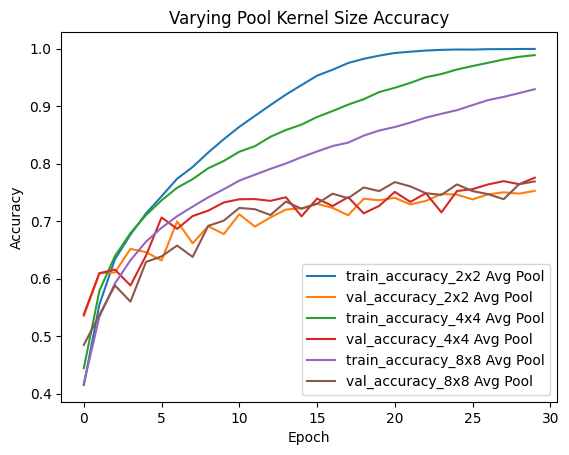

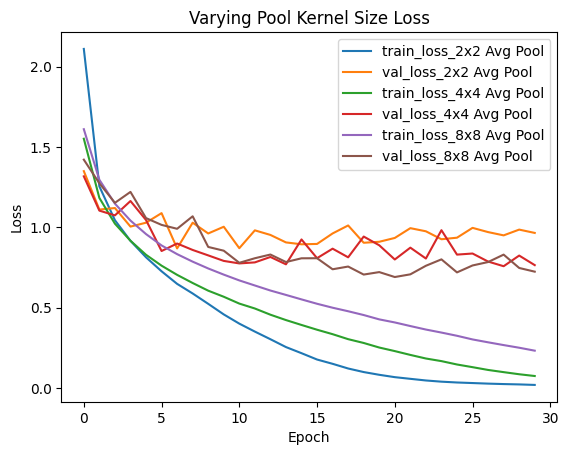

In [195]:
# Plot accuracy and loss
# accuracy_title = title + ' Accuracy'
# loss_title = title + ' Loss'
# plot_accuracy(resnet_history, accuracy_title)
# plot_loss(resnet_history, loss_title)

# Plot all models' accuracies and losses on the same graph:
plot_multiple_accuracies(histories, title)
plot_multiple_losses(histories, title)

In [196]:
# Load the model with the maximum validation accuracy from checkpoint on disk
test_model_1 = tf.keras.models.load_model(checkpoint_filepath_1)
test_model_2 = tf.keras.models.load_model(checkpoint_filepath_2)
test_model_3 = tf.keras.models.load_model(checkpoint_filepath_3)
test_model_4 = tf.keras.models.load_model(checkpoint_filepath_4)

In [197]:
# Evaluate test set using best version of each model and save outputs to a file
print(title + ':')
accuracy_list = []
for i in range(len(models)):
    accuracy_list.append(evaluate_model(models[i], X_test, Y_test))

with open("Test_Accuracy.txt", 'a') as file:
    file_title = title + ':\n'
    file.write(file_title)
    for i in range(len(accuracy_list)):
        acc_string = str(keys[i]) + '\t' + str(accuracy_list[i]) + '\n'
        file.write(acc_string)
    file.write('\n')

Varying Pool Kernel Size:
Test Accuracy: 75.16%
Test Accuracy: 75.92%
Test Accuracy: 76.40%


In [198]:
# from playsound import playsound
# playsound("GOT TO GO.mp3")
# playsound("GOT TO GO.mp3")
# playsound("GOT TO GO.mp3")

In [199]:
# Extra setup for loading specific models and evaluating
# test_model = tf.keras.models.load_model("ckpt\Baseline ResNet Model\Baseline")
# evaluate_model(test_model, X_test, Y_test)